Comparison analysis complete. Results saved in performance_comparison


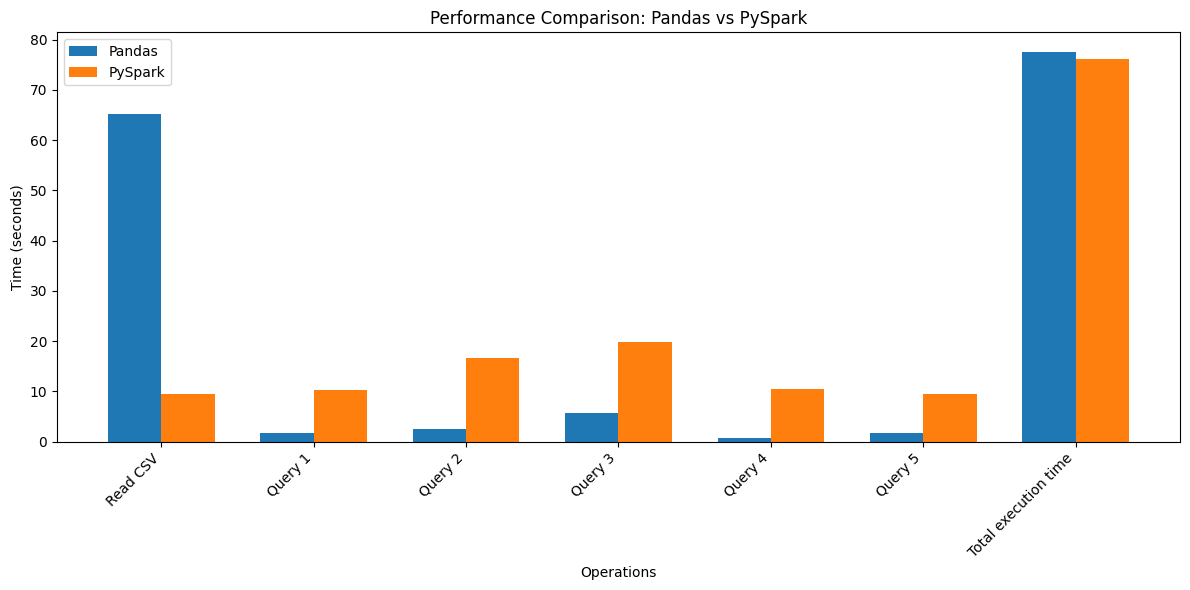

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import re
from datetime import datetime


def parse_timing_file(file_path):
    """Parse a timing file and extract operation names and durations."""
    with open(file_path, "r") as f:
        lines = f.readlines()

    timings = {}
    for line in lines:
        if ":" in line and "seconds" in line:
            operation = line.split(":")[0].strip()
            duration = float(re.search(r"(\d+\.\d+) seconds", line).group(1))
            timings[operation] = duration

    return timings


def create_comparison_report():
    # Get the latest timing files for both pandas and pyspark
    performance_dir = Path("performance_results")
    pandas_files = sorted(glob.glob(str(performance_dir / "pandas_timing_*.txt")))
    pyspark_files = sorted(glob.glob(str(performance_dir / "pyspark_timing_*.txt")))

    if not pandas_files or not pyspark_files:
        raise Exception("No timing files found!")

    # Get most recent files
    latest_pandas = pandas_files[-1]
    latest_pyspark = pyspark_files[-1]

    # Parse timing data
    pandas_timings = parse_timing_file(latest_pandas)
    pyspark_timings = parse_timing_file(latest_pyspark)

    # Create comparison DataFrame
    comparison_data = []
    for operation in pandas_timings.keys():
        comparison_data.append(
            {
                "Operation": operation,
                "Pandas Time (s)": pandas_timings.get(operation, 0),
                "PySpark Time (s)": pyspark_timings.get(operation, 0),
            }
        )

    df_comparison = pd.DataFrame(comparison_data)
    df_comparison["Speedup Factor"] = (
        df_comparison["Pandas Time (s)"] / df_comparison["PySpark Time (s)"]
    )

    # Create visualization
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(df_comparison))

    plt.bar(index, df_comparison["Pandas Time (s)"], bar_width, label="Pandas")
    plt.bar(
        [i + bar_width for i in index],
        df_comparison["PySpark Time (s)"],
        bar_width,
        label="PySpark",
    )

    plt.xlabel("Operations")
    plt.ylabel("Time (seconds)")
    plt.title("Performance Comparison: Pandas vs PySpark")
    plt.xticks(
        [i + bar_width / 2 for i in index],
        df_comparison["Operation"],
        rotation=45,
        ha="right",
    )
    plt.legend()
    plt.tight_layout()

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    comparison_dir = Path("performance_comparison")
    comparison_dir.mkdir(exist_ok=True)

    # Save plot
    plt.savefig(comparison_dir / f"performance_comparison_{timestamp}.png")

    # Save detailed comparison to CSV
    df_comparison.to_csv(
        comparison_dir / f"timing_comparison_{timestamp}.csv", index=False
    )

    # Generate summary report
    total_pandas = df_comparison["Pandas Time (s)"].sum()
    total_pyspark = df_comparison["PySpark Time (s)"].sum()
    overall_speedup = (
        total_pandas / total_pyspark if total_pyspark > 0 else float("inf")
    )

    report = [
        "Performance Comparison Summary",
        "===========================",
        f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"\nTotal Execution Times:",
        f"Pandas: {total_pandas:.2f} seconds",
        f"PySpark: {total_pyspark:.2f} seconds",
        f"Overall Speedup Factor: {overall_speedup:.2f}x",
        f"\nDetailed Operation Times:",
        df_comparison.to_string(),
        f"\nFastest Operations in Pandas:",
        (
            df_comparison[df_comparison["Speedup Factor"] < 1].to_string()
            if len(df_comparison[df_comparison["Speedup Factor"] < 1]) > 0
            else "None"
        ),
        f"\nFastest Operations in PySpark:",
        (
            df_comparison[df_comparison["Speedup Factor"] > 1].to_string()
            if len(df_comparison[df_comparison["Speedup Factor"] > 1]) > 0
            else "None"
        ),
    ]

    # Save report
    with open(comparison_dir / f"performance_report_{timestamp}.txt", "w") as f:
        f.write("\n".join(report))

    print(f"Comparison analysis complete. Results saved in {comparison_dir}")
    return df_comparison


if __name__ == "__main__":
    create_comparison_report()

In [5]:
pd.read_csv("./data/employee_records.csv").size

18750000